In [2]:
from dotenv import load_dotenv
from service.s3_storage_service import S3StorageService
from storage.s3_client import S3Client
from service.nrfa_data_service import NRFADataService

load_dotenv() # Load environment variable with the bucket name. 
s3_client = S3Client().get_client()
s3_service = S3StorageService(s3_client)
nrfa_service = NRFADataService(s3_service)

def find_pot_stage_with_most_dates():
    max_events = 0
    selected_station_id = None
    selected_key = None
    prefix = "nrfa_stations"  # Adjust based on your S3 bucket's structure

    # Retrieve the list of station folders (keys) in S3
    station_ids = s3_service.load_json_from_s3('nrfa_stations_metadata/station_ids.json')
    
    for station_id in station_ids:
        pot_stage_key = f"{prefix}/{station_id}/pot-stage.json"
        try:
            pot_stage_data = s3_service.load_json_from_s3(pot_stage_key)
            data_stream = pot_stage_data.get("data-stream", [])
            num_events = len(data_stream) // 2  # Each event has a date and a value
            if num_events > max_events:
                max_events = num_events
                selected_station_id = station_id 
                selected_key = pot_stage_key
        except EnvironmentError as e:
            print(f"Failed to load or process {pot_stage_key}: {e}")
    
    return selected_station_id, selected_key, max_events

# Assuming `s3_service` is already configured and available
station_id, s3_key, num_events = find_pot_stage_with_most_dates()
if station_id:
    print(f"Station with most events: {station_id} with {num_events} events. S3 Key: {s3_key}")
else:
    print("No station found or no data available in S3.")

KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd

def load_and_process_file(file_path):
    date_column = 'date'
    value_column = 'value'
    
    # Extract the data type from the file name
    # Assuming file name format is "data-type.csv"
    data_type = os.path.basename(file_path).split('.')[0]
    
    # Load the file with date parsing
    df = pd.read_csv(file_path, usecols=[date_column, value_column], parse_dates=[date_column], dayfirst=True)
    
    # Rename the value column to the data type extracted from the file name
    df.rename(columns={value_column: data_type}, inplace=True)
    
    return df


directory = 'measurements'
all_files = os.listdir(directory)

combined_df = None

for file in all_files:
    if file.endswith('.csv'):
        file_path = os.path.join(directory, file)
        df = load_and_process_file(file_path)
        
        if combined_df is None:
            combined_df = df
        else:
            # Merge on 'date', aligning data by date
            combined_df = pd.merge(combined_df, df, on='date', how='outer')

# Ensure the DataFrame is sorted by date
combined_df.sort_values(by='date', inplace=True)

# Reset index after sorting
combined_df.reset_index(drop=True, inplace=True)

combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df.set_index('date', inplace=True)


print(combined_df.head())
print(combined_df.tail())



In [69]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = combined_df.dropna()
print(df.head())

# Normalize each column while keeping NaN intact
for column in df.columns:
    # Extract column without NaNs for scaling
    series = df[column]
    mask = series.notna()
    values_to_scale = series[mask].values.reshape(-1, 1)
    
    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values_to_scale)
    
    # Put scaled values back into the DataFrame
    df.loc[mask, column] = scaled_values.flatten()

print(df)

         date  fdmean
0  1944-01-01    31.9
1  1944-01-02    27.5
2  1944-01-03    24.7
3  1944-01-04    51.1
4  1944-01-05    30.4
               ldmin     ldmax     fdmax     fdmin    fdmean
date                                                        
1970-01-03  0.152468  0.136830  0.049783  0.061648  0.058347
1970-01-03  0.152468  0.136830  0.059002  0.061648  0.058347
1970-01-03  0.152468  0.153105  0.049783  0.061648  0.058347
1970-01-03  0.152468  0.153105  0.059002  0.061648  0.058347
1970-01-05  0.124539  0.111708  0.036942  0.045778  0.034166
...              ...       ...       ...       ...       ...
2023-10-04  0.256631  0.230210  0.104768  0.129807  0.094879
2023-10-05  0.214298  0.192289  0.081555  0.100916  0.076091
2023-10-08  0.173898  0.155791  0.060319  0.074873  0.054693
2023-10-09  0.147550  0.132248  0.046490  0.057782  0.043038
2023-10-10  0.131565  0.118028  0.038424  0.047609  0.036601

[20150 rows x 5 columns]


In [70]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalize each column while keeping NaN intact
for column in df.columns:
    # Extract column without NaNs for scaling
    series = df[column]
    mask = series.notna()
    values_to_scale = series[mask].values.reshape(-1, 1)
    
    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values_to_scale)
    
    # Put scaled values back into the DataFrame
    df.loc[mask, column] = scaled_values.flatten()

# df.dropna()    
print(df.head())
print(df.tail())

               ldmin     ldmax     fdmax     fdmin    fdmean
date                                                        
1970-01-03  0.152468  0.136830  0.049783  0.061648  0.058347
1970-01-03  0.152468  0.136830  0.059002  0.061648  0.058347
1970-01-03  0.152468  0.153105  0.049783  0.061648  0.058347
1970-01-03  0.152468  0.153105  0.059002  0.061648  0.058347
1970-01-05  0.124539  0.111708  0.036942  0.045778  0.034166
               ldmin     ldmax     fdmax     fdmin    fdmean
date                                                        
2023-10-04  0.256631  0.230210  0.104768  0.129807  0.094879
2023-10-05  0.214298  0.192289  0.081555  0.100916  0.076091
2023-10-08  0.173898  0.155791  0.060319  0.074873  0.054693
2023-10-09  0.147550  0.132248  0.046490  0.057782  0.043038
2023-10-10  0.131565  0.118028  0.038424  0.047609  0.036601


In [71]:
def create_sequences(data, target_column, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in)].to_numpy())
        y.append(data[target_column][i + n_steps_in:i + n_steps_in + n_steps_out].to_numpy())
    return np.array(X), np.array(y)

# df.fillna(-999, inplace=True)
# df.dropna()
# Create sequences after scaling
X, y = create_sequences(df, target_column='ldmax', n_steps_in=42, n_steps_out=1)

print(X.shape, y.shape)

(20108, 42, 5) (20108, 1)


In [72]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [73]:
import numpy as np

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print("NaN in y_train:", np.isnan(y_train).any())
print("NaN in y_test:", np.isnan(y_test).any())

print(X_train[0], y_train[0])
print(X_test[0], y_test[0])


Training set: (16086, 42, 5), (16086, 1)
Test set: (4022, 42, 5), (4022, 1)
NaN in y_train: False
NaN in y_test: False
[[0.15246794 0.13683046 0.04978269 0.06164802 0.05834667]
 [0.15246794 0.13683046 0.05900171 0.06164802 0.05834667]
 [0.15246794 0.15310476 0.04978269 0.06164802 0.05834667]
 [0.15246794 0.15310476 0.05900171 0.06164802 0.05834667]
 [0.12453891 0.11170801 0.03694192 0.04577823 0.03416603]
 [0.10521693 0.10601991 0.03430792 0.03601221 0.03399207]
 [0.10521693 0.10601991 0.03430792 0.03540183 0.03399207]
 [0.10416301 0.10601991 0.03430792 0.03601221 0.03399207]
 [0.10416301 0.10601991 0.03430792 0.03540183 0.03399207]
 [0.10750044 0.09922579 0.03118003 0.0370295  0.03868903]
 [0.18022132 0.15800284 0.06180034 0.07934893 0.14550136]
 [0.18022132 0.15800284 0.18016594 0.07934893 0.14550136]
 [0.18022132 0.31584769 0.06180034 0.07934893 0.14550136]
 [0.18022132 0.31584769 0.18016594 0.07934893 0.14550136]
 [0.36553662 0.32848791 0.19168971 0.2370295  0.20151694]
 [0.3815211

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

model = Sequential([
    Masking(mask_value=-9.99000000e+02, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),  # Change to True if adding more LSTM layers below
    Dropout(0.2),
    Dense(1)  # Adjust the number of neurons to match the output shape, if not 1
])

# Compile the model for a regression problem
model.compile(optimizer='rmsprop', loss='mae')

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Epoch 1/30
403/403 [==============================] - 5s 10ms/step - loss: 0.0386 - val_loss: 0.0458
Epoch 2/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0305 - val_loss: 0.0299
Epoch 3/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0285 - val_loss: 0.0334
Epoch 4/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0277 - val_loss: 0.0315
Epoch 5/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0272 - val_loss: 0.0357
Epoch 6/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0272 - val_loss: 0.0287
Epoch 7/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0267 - val_loss: 0.0325
Epoch 8/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0267 - val_loss: 0.0323
Epoch 9/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0266 - val_loss: 0.0279
Epoch 10/30
403/403 [==============================] - 3s 8ms/step - loss: 0.0263 - val_loss: 0.027

In [88]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential([
    Masking(mask_value=np.nan, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128),  # Change to True if adding more LSTM layers below
    # Dropout(0.2),
    Dense(1)  # Adjust the number of neurons to match the output shape, if not 1
])

# Compile the model for a regression problem
model_GRU.compile(optimizer='rmsprop', loss='mae')


# Fit the model
history_GRU = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss_GRU = model_GRU.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss_GRU}")


Epoch 1/20
403/403 [==============================] - 3s 8ms/step - loss: 0.0263 - val_loss: 0.0277
Epoch 2/20
403/403 [==============================] - 3s 8ms/step - loss: 0.0263 - val_loss: 0.0288
Epoch 3/20
403/403 [==============================] - 3s 8ms/step - loss: 0.0263 - val_loss: 0.0282
Epoch 4/20
403/403 [==============================] - 3s 8ms/step - loss: 0.0261 - val_loss: 0.0295
Epoch 5/20
403/403 [==============================] - 3s 8ms/step - loss: 0.0262 - val_loss: 0.0313
Epoch 6/20
219/403 [===============>..............] - ETA: 1s - loss: 0.0263

KeyboardInterrupt: 

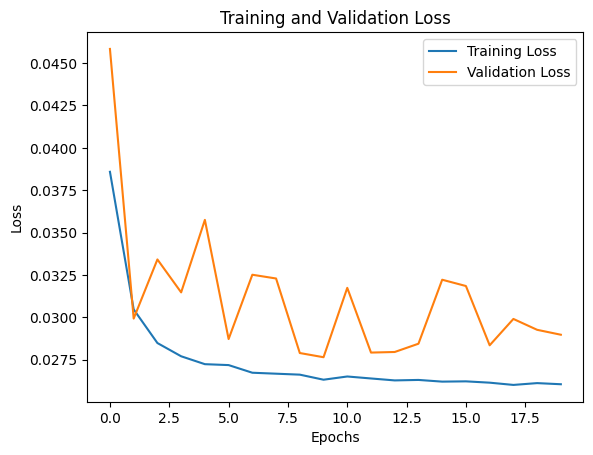

In [81]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

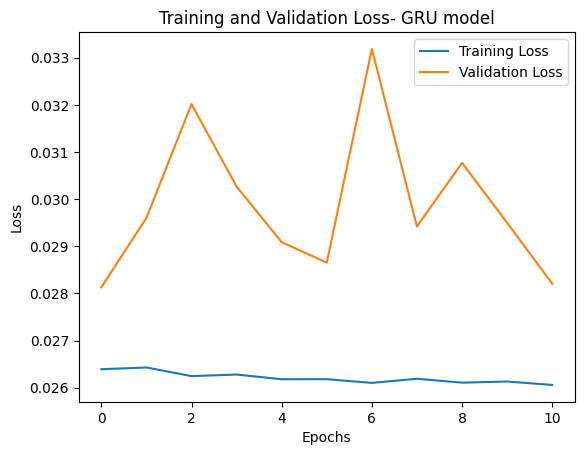

In [82]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss- GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

126/126 [==============================] - 1s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


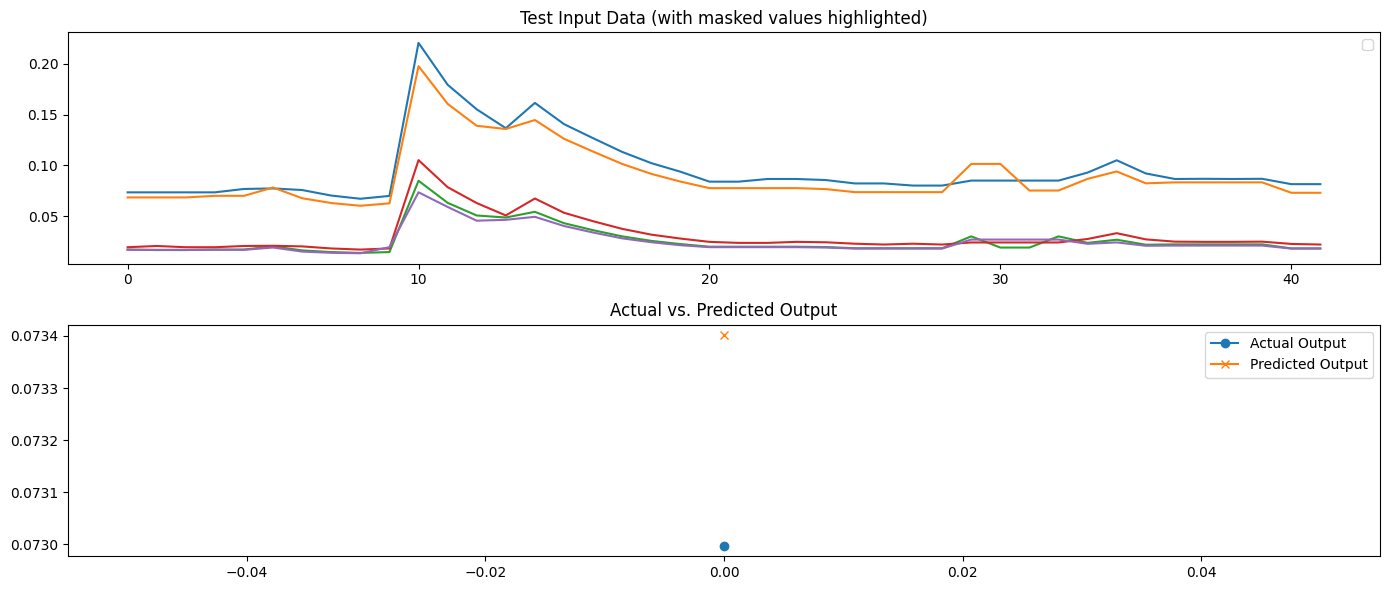

In [83]:
# # Generate predictions for the test set
# 
# 
# test_predictions = model.predict(X_test)
# 
# # Assuming test_predictions and y_test are log-scaled
# original_test_predictions = np.exp(test_predictions) - 1
# original_y_test = np.exp(y_test) - 1
# 
# 
# 
# # Now, original_test_predictions and original_y_test are in the original scale
# 
# # Assuming y_test and test_predictions are scaled, rescale them back if necessary
# # Here, I'm assuming they're already appropriately scaled or transformed
import matplotlib.pyplot as plt

# Assuming X_test and y_test are your test inputs and outputs
# Let's say 'n' is an index of a test sample you want to inspect

def plot_test_data_with_predictions(X_test, y_test, predictions, n):
    plt.figure(figsize=(14, 6))
    
    # Plot original test input data
    plt.subplot(2, 1, 1)
    plt.plot(X_test[n])
    plt.title('Test Input Data (with masked values highlighted)')
    plt.legend()

    # Plot actual test output and predicted output
    plt.subplot(2, 1, 2)
    plt.plot(y_test[n], label='Actual Output', marker='o')
    plt.plot(predictions[n], label='Predicted Output', marker='x')
    plt.title('Actual vs. Predicted Output')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate predictions for test set
predictions = model.predict(X_test)
predictions_GRU = model_GRU.predict(X_test)

# Assuming test_predictions and y_test are log-scaled
original_test_predictions = np.exp(predictions) - 1
original_y_test = np.exp(y_test) - 1

original_test_predictions_GRU = np.exp(predictions_GRU) - 1
original_y_test_GRU = np.exp(y_test) - 1

# Now, original_test_predictions and original_y_test are in the original scale

# Assuming y_test and test_predictions are scaled, rescale them back if necessary
# Here, I'm assuming they're already appropriately scaled or transformed

# Example usage for the first test sample
plot_test_data_with_predictions(X_test, y_test, predictions, n=0)

IndexError: list index out of range

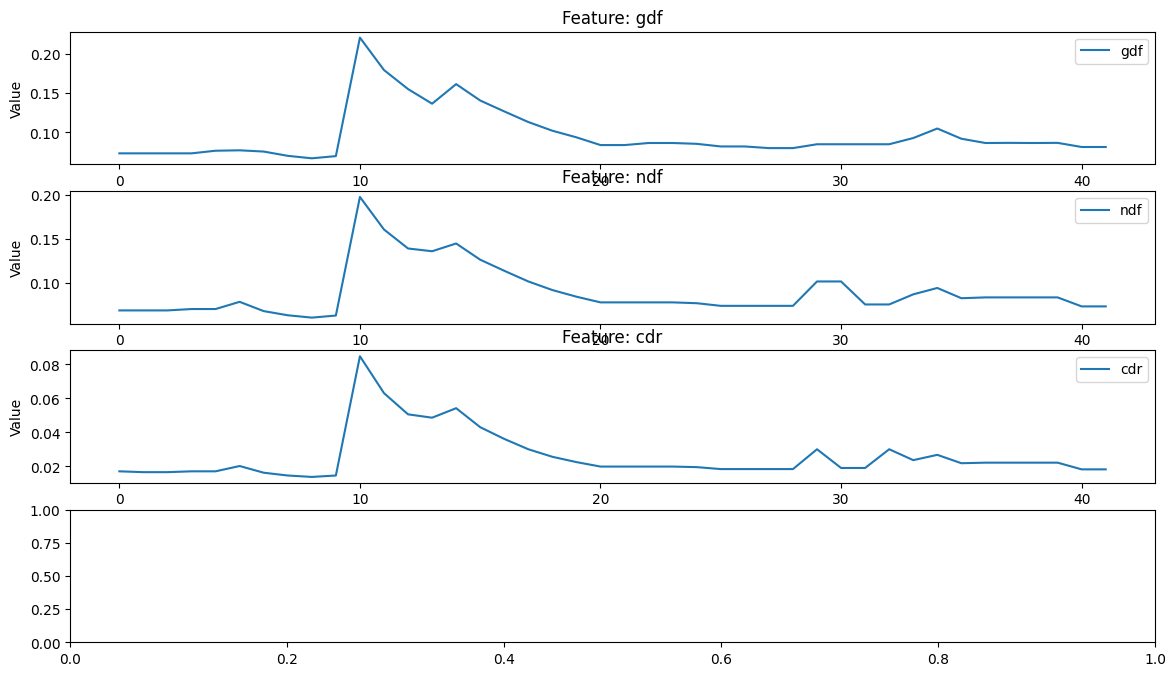

In [84]:
import matplotlib.pyplot as plt

def plot_features_of_sample(X_test, sample_index=0):
    # Number of features in the dataset
    num_features = X_test.shape[2]
    
    # Prepare the plot
    plt.figure(figsize=(14, num_features * 2))
    
    # Feature names (adjust according to your dataset)
    feature_names = ['gdf', 'ndf', 'cdr'] # Add or remove names based on your features
    
    # Plot each feature
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(X_test[sample_index, :, i], label=f'{feature_names[i]}')
        plt.title(f'Feature: {feature_names[i]}')
        plt.xlabel('Timestep')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage: plot features for the first sample in the test set
plot_features_of_sample(X_test, sample_index=0)



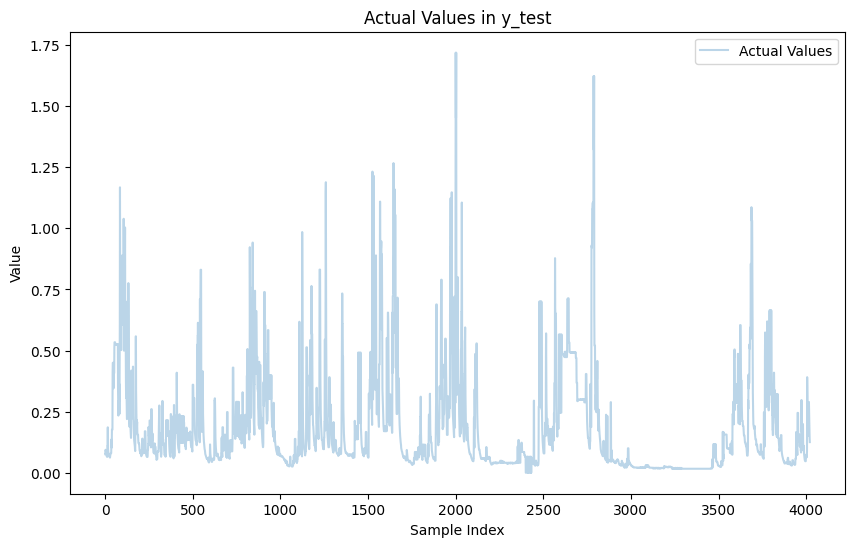

In [85]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual values you want to plot
plt.figure(figsize=(10, 6))
plt.plot(original_y_test, label='Actual Values', alpha=0.3)

plt.title('Actual Values in y_test')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


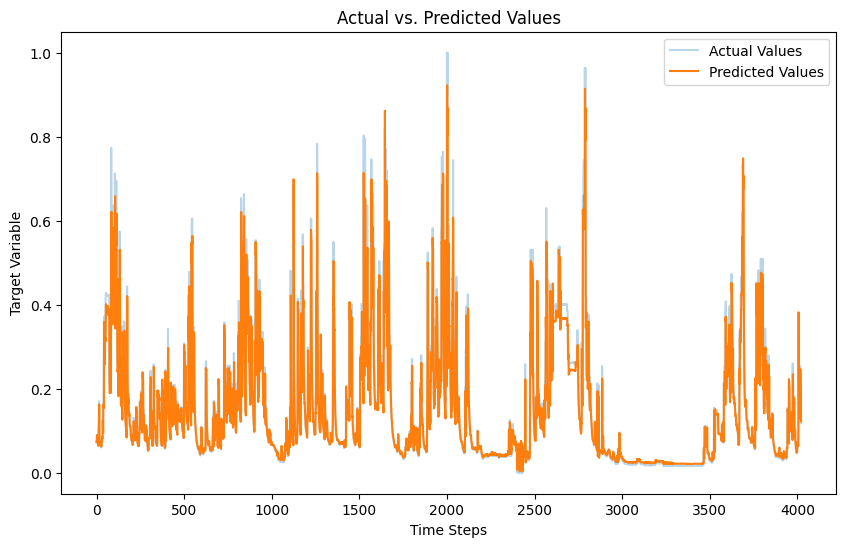

In [86]:
import matplotlib.pyplot as plt

# Optional: Rescale predictions and actual values back to original scale if they were scaled/transformed
# If you used MinMaxScaler or another scaling method on your target variable, invert that process here

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values',alpha=0.3)
plt.plot(predictions, label='Predicted Values', alpha=1.0)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable')
plt.legend()
plt.show()


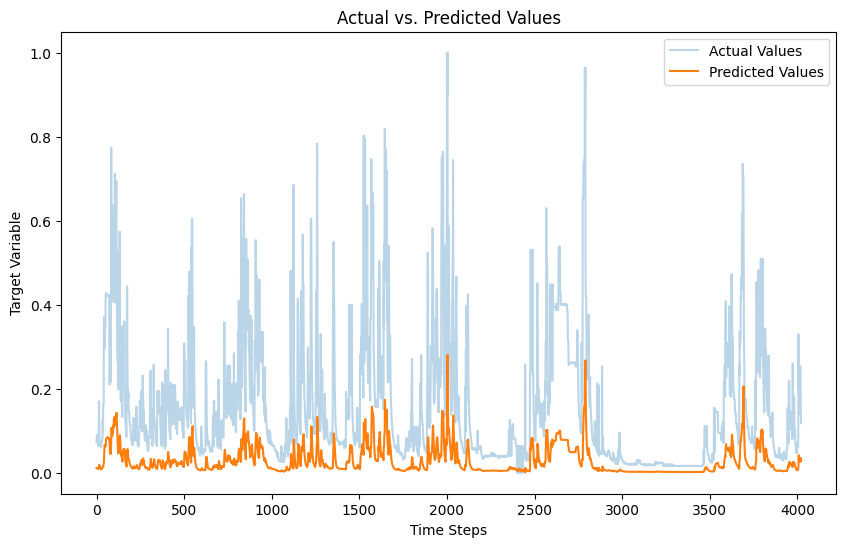

In [87]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values',alpha=0.3)
plt.plot(predictions_GRU, label='Predicted Values', alpha=1.0)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Target Variable')
plt.legend()
plt.show()